In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import PredictionErrorDisplay
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
df = pd.read_csv('ARE-Historical-Data-2015.csv', index_col='Date', parse_dates=True)

In [3]:
df = df.iloc[::-1]

In [4]:
df1=df.reset_index()['Price']

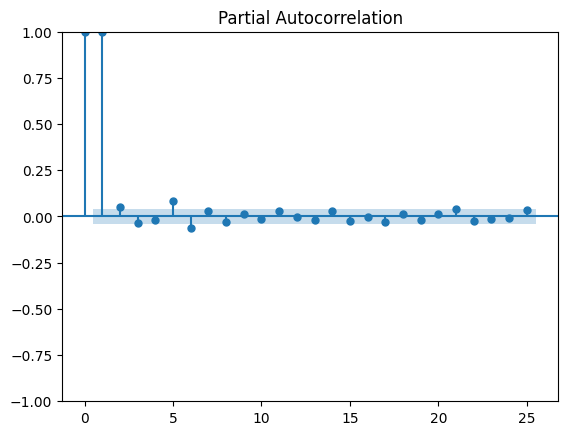

In [30]:
plot_pacf(df1, lags=25)
plt.show()

In [5]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [7]:
def create_dataset(dataset, lookback, horizon):
    X, y = [], []
    for i in range(len(dataset)-lookback-horizon+1):
        X.append(dataset[i:(i+lookback), :])
        y.append(dataset[(i+lookback):(i+lookback+horizon), 0])
    return np.array(X), np.array(y)

In [8]:
lookback = 25
horizon = 12
n_features = 1

In [9]:
X_train, y_train = create_dataset(train_data, lookback, horizon)
X_test, y_test = create_dataset(test_data, lookback, horizon)
X_val, y_val = create_dataset(val_data, lookback, horizon)

In [10]:
model = Sequential()
model.add(LSTM(64, input_shape=(lookback, n_features), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(horizon))
model.compile(loss='mse', optimizer='adam')

In [11]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)

Epoch 1/50
46/46 - 4s - loss: 0.0318 - val_loss: 0.0070 - 4s/epoch - 79ms/step
Epoch 2/50
46/46 - 1s - loss: 0.0016 - val_loss: 0.0066 - 510ms/epoch - 11ms/step
Epoch 3/50
46/46 - 1s - loss: 0.0014 - val_loss: 0.0064 - 512ms/epoch - 11ms/step
Epoch 4/50
46/46 - 0s - loss: 0.0013 - val_loss: 0.0065 - 499ms/epoch - 11ms/step
Epoch 5/50
46/46 - 1s - loss: 0.0014 - val_loss: 0.0072 - 501ms/epoch - 11ms/step
Epoch 6/50
46/46 - 1s - loss: 0.0013 - val_loss: 0.0065 - 504ms/epoch - 11ms/step
Epoch 7/50
46/46 - 1s - loss: 0.0013 - val_loss: 0.0056 - 510ms/epoch - 11ms/step
Epoch 8/50
46/46 - 0s - loss: 0.0013 - val_loss: 0.0049 - 497ms/epoch - 11ms/step
Epoch 9/50
46/46 - 1s - loss: 0.0013 - val_loss: 0.0055 - 512ms/epoch - 11ms/step
Epoch 10/50
46/46 - 1s - loss: 0.0012 - val_loss: 0.0048 - 525ms/epoch - 11ms/step
Epoch 11/50
46/46 - 1s - loss: 0.0012 - val_loss: 0.0053 - 514ms/epoch - 11ms/step
Epoch 12/50
46/46 - 1s - loss: 0.0012 - val_loss: 0.0047 - 532ms/epoch - 12ms/step
Epoch 13/50
46/4

In [12]:
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

6/6 [==============================] - 0s 3ms/step


In [13]:
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [14]:
y_pred = [y_pred[i][0] for i in range(len(y_pred))]
y_pred_val = [y_pred_val[i][0] for i in range(len(y_pred_val))]

In [15]:
num_predictions = 30
initial_input = X_val[-1]
initial_input = initial_input.reshape(1, lookback, n_features)
next30days_predictions = []
for _ in range(num_predictions):
    next_pred = model.predict(initial_input)
    next30days_predictions.append(next_pred[0])
    initial_input = np.append(initial_input[:, 1:, :], next_pred.reshape(1, horizon, n_features), axis=1)
# next30days_predictions = np.array(next30days_predictions).reshape(-1, 1)
next30days_predictions = scaler.inverse_transform(next30days_predictions)

1/1 [==============================] - 0s 36ms/step


In [16]:
next30days_predictions=[next30days_predictions[i][0] for i in range(len(next30days_predictions))]

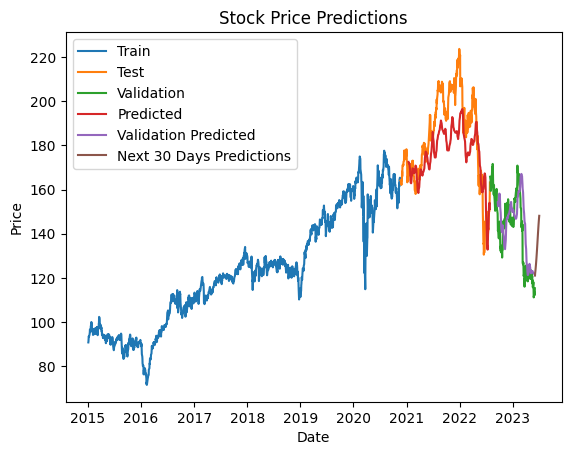

In [17]:
# Create a list of dates for the x-axis
dates_train = df.index[:train_size]
dates_test = df.index[train_size:train_size+test_size]
dates_val = df.index[train_size+test_size:train_size+test_size+val_size]
dates_pred = df.index[train_size+lookback+horizon-1:train_size+test_size]
dates_pred_val = df.index[train_size+test_size+lookback+horizon-1:train_size+test_size+val_size]
dates_next30days = pd.date_range(start=df.index[-1], periods=num_predictions+1)[1:]


# Plotting the chart
plt.plot(dates_train, scaler.inverse_transform(train_data), label='Train')
plt.plot(dates_test, scaler.inverse_transform(test_data), label='Test')
plt.plot(dates_val, scaler.inverse_transform(val_data), label='Validation')
plt.plot(dates_pred, y_pred, label='Predicted')
plt.plot(dates_pred_val, y_pred_val, label='Validation Predicted')
plt.plot(dates_next30days, next30days_predictions, label='Next 30 Days Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Predictions')
plt.legend()
plt.show()